In [1]:
#!apt-get update --fix-missing
!pip install QuantLib

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import QuantLib as ql
import sys, os
import tensorflow.keras.backend as K
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.compat.v1.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
#from scipy.stats import norm

# import helper functions
!rm -rf deep-hedging
!git clone https://github.com/YuMan-Tam/deep-hedging
sys.path.insert(0, os.getcwd() + "/deep-hedging")
from stochastic_processes import BlackScholesProcess
from instruments import EuropeanCall

     |████████████████████████████████| 17.9 MB 23.0 MB/s 
Cloning into 'deep-hedging'...
remote: Enumerating objects: 974, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 974 (delta 3), reused 2 (delta 0), pack-reused 965
Receiving objects: 100% (974/974), 147.90 MiB | 34.54 MiB/s, done.
Resolving deltas: 100% (545/545), done.


In [2]:
initializer = tf.keras.initializers.HeUniform()
def NN(N, d, m, model_type, epsilon = 0.0):

  S = Input(shape=(1,))                                        
  I = Input(shape=(1,))
  inputs = [S,I]                                    
  for i in range(N):   
    S_new = Input(shape=(1,))
    I_new = Input(shape=(1,))  
    inputs = inputs + [S_new, I_new]
    
    if i ==0:
      strategy = 0.0 * I  
      PL = 0.0 * I                  

    # build the network
    if model_type == 'recurrent':
      hidden_state = Concatenate()([I,strategy])     
    else:
      hidden_state = I
       
    for j in range(d):
      if j == 0:
        output = Dense(m,kernel_initializer=initializer,
                       bias_initializer=initializer)(hidden_state)
      else:
        output = Dense(m,kernel_initializer=initializer,
                       bias_initializer=initializer)(output)                        
      output = LeakyReLU()(output)
    
    strategy_now = Dense(1, activation='sigmoid')(output)  
            
    PL = PL + strategy_now * (S_new - S)
    PL = PL - (strategy_now - strategy) * S
    PL = PL - epsilon * K.abs(strategy_now - strategy) * S

    # Update
    S = S_new
    strategy = strategy_now
    I = I_new
                       
  payoff = Input(shape=(1,))
  inputs = inputs + [payoff]       
  PL = PL - payoff

  return Model(inputs=inputs, outputs=PL)

In [3]:
seed = 0

N = 30  # number of time steps
S0 = 100
strike = 100
sigma = 0.2
day_count = ql.Actual365Fixed() # day convention
mc_simulator = "QuantLib" # "QuantLib" or "Numpy"
calculation_date = ql.Date.todaysDate()
maturity_date = ql.Date.todaysDate() + N
dt = day_count.yearFraction(calculation_date,calculation_date + 1) 
maturity = N*dt

size_train = 80000
size_test = 20000
size_total = size_train + size_test
test_ratio = size_test/size_total

# generate the sample paths
stochastic_process = BlackScholesProcess(s0 = S0, sigma = sigma, risk_free = 0.0, \
                        dividend = 0.0, day_count = day_count, seed=seed)
S = stochastic_process.gen_path(maturity, N, size_total)

100%|██████████| 100000/100000 [00:12<00:00, 7700.07it/s]


In [6]:
payoff_T = np.maximum(S[:,-1] - strike, 0)  # European call payoff
I = np.log(S/S0)

S_train, S_test = train_test_split(S, test_size = test_ratio, shuffle=False)
I_train, I_test = train_test_split(I, test_size = test_ratio, shuffle=False)
payoff_train, payoff_test = train_test_split(payoff_T, test_size = test_ratio, shuffle=False)
payoff_train = payoff_train[:,None]
payoff_test = payoff_test[:,None]

xtrain=[]
xtest=[]
for i in range(N+1):
  xtrain = xtrain + [S_train[:,i,None]]
  xtrain = xtrain + [I_train[:,i,None]]
  xtest = xtest + [S_test[:,i,None]]
  xtest = xtest + [I_test[:,i,None]]

xtrain = xtrain + [payoff_train]
xtest = xtest + [payoff_test]

In [7]:
# define the risk measures
def Entropy(PL, lambda0):
  return 1/lambda0 * K.log(K.mean(K.exp(-lambda0 * PL)))

def CVaR(PL, alpha):
  VaR = -tfp.stats.percentile(PL, 100*(1-alpha))
  return VaR + 1/(1-alpha) * K.mean(K.maximum(-PL - VaR, 0))

In [8]:
d = 3  # number of layers
m = 16  # number of neurons in each layer
batch_size = 256
epochs = 30

epsilon = 0.01

In [9]:
# Recurrent Model
risk_measure = 'Entropy'
recurrent_model = NN(N, d, m, 'recurrent', epsilon)
if risk_measure=='Entropy':
  lambda0 = 1
  loss = Entropy(recurrent_model.output, lambda0)
elif risk_measure=='CVaR':
  alpha = 0.95
  loss = CVaR(recurrent_model.output, alpha)
recurrent_model.add_loss(loss)
recurrent_model.compile(optimizer=Adam(learning_rate=0.005))

callback = EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
recurrent_model.fit(x=xtrain, batch_size=batch_size, callbacks=[callback], epochs=epochs)


Epoch 1/10
313/313 [==============================] - 20s 27ms/step - loss: 6.0334
Epoch 2/10
313/313 [==============================] - 5s 16ms/step - loss: 3.7772
Epoch 3/10
313/313 [==============================] - 5s 16ms/step - loss: 3.7317
Epoch 4/10
313/313 [==============================] - 5s 15ms/step - loss: 3.7173
Epoch 5/10
313/313 [==============================] - 5s 15ms/step - loss: 3.7097
Epoch 6/10
313/313 [==============================] - 5s 16ms/step - loss: 3.7112
Epoch 7/10
313/313 [==============================] - 5s 16ms/step - loss: 3.6956
Epoch 8/10
313/313 [==============================] - 5s 16ms/step - loss: 3.6923
Epoch 9/10
313/313 [==============================] - 6s 19ms/step - loss: 3.6873
Epoch 10/10
313/313 [==============================] - 8s 26ms/step - loss: 3.6881


In [23]:
# Simple Model
risk_measure = 'Entropy'
simple_model = NN(N, d, m, 'simple', epsilon)
if risk_measure=='Entropy':
  lambda0 = 1
  loss = Entropy(simple_model.output, lambda0)
elif risk_measure=='CVaR':
  alpha = 0.95
  loss = CVaR(simple_model.output, alpha)
  #loss = CVaR(simple_model.output, -tfp.stats.percentile(simple_model.output, 100*(1-alpha)), alpha)
simple_model.add_loss(loss)
simple_model.compile(optimizer=Adam(learning_rate=0.005))

callback = EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
simple_model.fit(x=xtrain, batch_size=batch_size, callbacks=[callback], epochs=epochs)


Epoch 1/10
313/313 [==============================] - 15s 16ms/step - loss: 5.2102
Epoch 2/10
313/313 [==============================] - 5s 16ms/step - loss: 3.8808
Epoch 3/10
313/313 [==============================] - 5s 16ms/step - loss: 3.8529
Epoch 4/10
313/313 [==============================] - 5s 16ms/step - loss: 3.8422
Epoch 5/10
313/313 [==============================] - 5s 16ms/step - loss: 3.8337
Epoch 6/10
313/313 [==============================] - 5s 16ms/step - loss: 3.8262
Epoch 7/10
313/313 [==============================] - 5s 16ms/step - loss: 3.8218
Epoch 8/10
313/313 [==============================] - 5s 16ms/step - loss: 3.8193
Epoch 9/10
313/313 [==============================] - 5s 15ms/step - loss: 3.8163
Epoch 10/10
313/313 [==============================] - 5s 16ms/step - loss: 3.8138


In [14]:
# calculate prices
call = EuropeanCall()

price_BS = call.get_BS_price(S = S_test, sigma = sigma, \
              risk_free = 0.0, dividend = 0.0, K = strike, \
              exercise_date = maturity_date, \
              calculation_date = calculation_date, \
              day_count = day_count, dt = dt)

delta_BS = call.get_BS_delta(S = S_test, sigma = sigma, \
              risk_free = 0.0, dividend = 0.0, K = strike, \
              exercise_date = maturity_date, \
              calculation_date = calculation_date, 
              day_count = day_count, dt = dt)

PnL_BS =  call.get_BS_PnL(S = S_test, \
              payoff= -payoff_test.reshape(size_test,), delta=delta_BS, \
              dt= dt, risk_free = 0.0, \
              final_period_cost = False, epsilon = epsilon, \
              cost_structure = 'proportional' )

#risk_neutral_price = payoff_test.mean()
risk_neutral_price = np.mean(payoff_test)
recurrent_price = recurrent_model.evaluate(xtest,verbose=0)
simple_price = simple_model.evaluate(xtest,verbose=0)

print("The Black-Scholes model price is %2.3f." % price_BS[0][0])
print("The Risk Neutral price is %2.3f." % risk_neutral_price)
print("The Deep Hedging (with simple network) price is %2.3f." % simple_price)
print("The Deep Hedging (with recurrent network) price is %2.3f." % recurrent_price)

The Black-Scholes model price is 2.287.
The Risk Neutral price is 2.262.
The Deep Hedging (with simple network) price is 5.250.
The Deep Hedging (with recurrent network) price is 3.647.


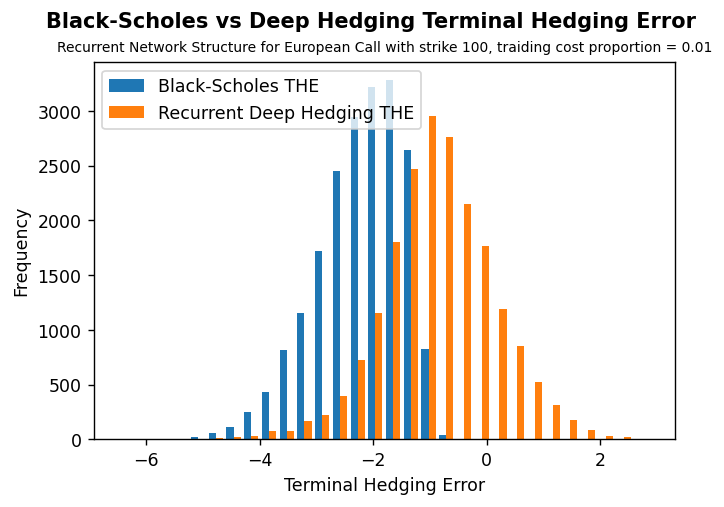

In [ ]:
# compare hedging errors (BS vs Recurrent)
bar1 = PnL_BS + price_BS[0][0]
bar2 = recurrent_model(xtest).numpy().squeeze() + price_BS[0][0]

fig_PnL = plt.figure(dpi= 125, facecolor='w')
fig_PnL.suptitle("Black-Scholes vs Deep Hedging Terminal Hedging Error \n", \
      fontweight="bold")
ax = fig_PnL.add_subplot()
ax.set_title("Recurrent Network Structure for European Call with strike "+str(strike)+", traiding cost proportion = "+str(epsilon), \
      fontsize=8)
ax.set_xlabel("Terminal Hedging Error")
ax.set_ylabel("Frequency")
ax.hist((bar1,bar2), bins=30, \
          label=["Black-Scholes THE", "Recurrent Deep Hedging THE"])
ax.legend()
plt.show()

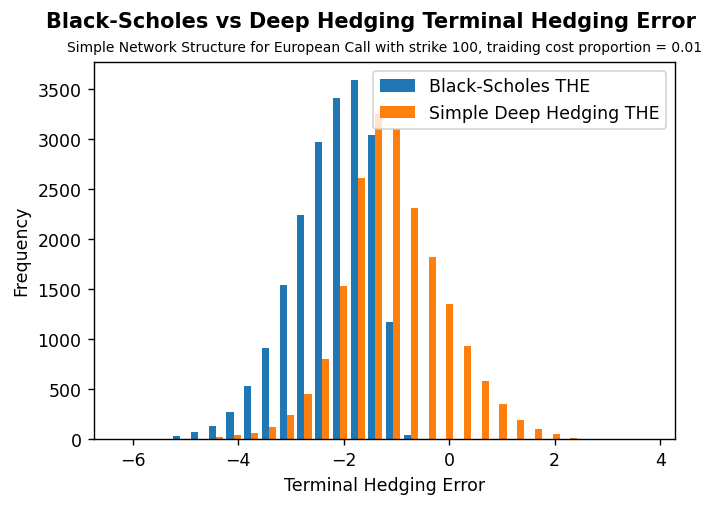

In [24]:
# compare hedging errors (BS vs Simple)
bar1 = PnL_BS + price_BS[0][0]
bar2 = simple_model(xtest).numpy().squeeze() + price_BS[0][0]

fig_PnL = plt.figure(dpi= 125, facecolor='w')
fig_PnL.suptitle("Black-Scholes vs Deep Hedging Terminal Hedging Error \n", \
      fontweight="bold")
ax = fig_PnL.add_subplot()
ax.set_title("Simple Network Structure for European Call with strike "+str(strike)+", traiding cost proportion = "+str(epsilon), \
      fontsize=8)
ax.set_xlabel("Terminal Hedging Error")
ax.set_ylabel("Frequency")
ax.hist((bar1,bar2), bins=30, \
          label=["Black-Scholes THE", "Simple Deep Hedging THE"])
ax.legend()
plt.show()

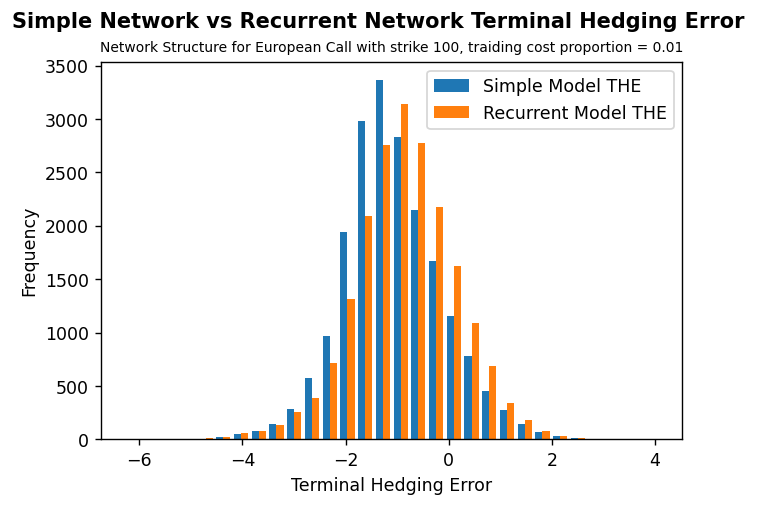

In [25]:
# compare hedging errors (Simple vs Recurrent)
bar1 = simple_model(xtest).numpy().squeeze() + price_BS[0][0]
bar2 = recurrent_model(xtest).numpy().squeeze() + price_BS[0][0]

fig_nn = plt.figure(dpi= 125, facecolor='w')

fig_nn.suptitle("Simple Network vs Recurrent Network Terminal Hedging Error \n ", \
      fontweight="bold")
ax = fig_nn.add_subplot()
ax.set_title("Network Structure for European Call with strike "+str(strike)+", traiding cost proportion = "+str(epsilon), \
      fontsize=8)
ax.set_xlabel("Terminal Hedging Error")
ax.set_ylabel("Frequency")
ax.hist((bar1,bar2), bins=30, \
          label=["Simple Model THE", "Recurrent Model THE"])
ax.legend()
plt.show()